<a href="https://colab.research.google.com/github/Riponcs/Deep_Learning/blob/master/Image%20Classification%20with%20ResNet50%20%5BData%20-%20Cifar%20100%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import h5py
import cv2
import numpy as np

import tensorflow as tf
import keras.backend as K
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Reshape, Multiply
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
from tensorflow.python.framework import ops

from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [0]:
def OneHotEncoding(Y, Col):
    Y = np.eye(Col)[Y.reshape(-1)].T
    return Y

K.set_image_data_format('channels_last')
K.set_learning_phase(1)


## ResNet50 With SE - attention network

In [0]:
def identity_block(out, f, filters, stage, B_Name):
  
    c_name = 'RES' + str(stage) + B_Name + '_branch'
    b_name = 'BN' + str(stage) + B_Name + '_branch'

    # Retrieve Filters
    Filter1, Filter2, Filter3 = filters

    out_shortcut = out

    # Section 1
    out = Conv2D(filters = Filter1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = c_name + '2A', kernel_initializer = glorot_uniform(seed=0))(out)
    out = BatchNormalization(axis = 3, name = b_name + '2A')(out)
    out = Activation('relu')(out)


    # Section 2
    out = Conv2D(filters = Filter2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = c_name + '2B', kernel_initializer = glorot_uniform(seed=0))(out)
    out = BatchNormalization(axis = 3, name = b_name + '2B')(out)
    out = Activation('relu')(out)

    # Section 3
    out = Conv2D(filters = Filter3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = c_name + '2C', kernel_initializer = glorot_uniform(seed=0))(out)
    out = BatchNormalization(axis = 3, name = b_name + '2C')(out)

    # skip Connection
    out = Add()([out, out_shortcut])
    out = Activation('relu')(out)

    return out

In [0]:
def convolutional_block(out, f, filters, stage, B_Name, s = 2):

    
    c_name = 'res' + str(stage) + B_Name + '_branch'
    b_name = 'bn' + str(stage) + B_Name + '_branch'
    
    # Filters
    Filter1, Filter2, Filter3 = filters
    
    # Save for skip connection
    out_shortcut = out

    # Section 1
    out = Conv2D(Filter1, (1, 1), strides = (s,s), name = c_name + '2A', kernel_initializer = glorot_uniform(seed=0))(out)
    out = BatchNormalization(axis = 3, name = b_name + '2A')(out)
    out = Activation('relu')(out)

    # Section 2
    out = Conv2D(filters = Filter2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = c_name + '2B', kernel_initializer = glorot_uniform(seed=0))(out)
    out = BatchNormalization(axis = 3, name = b_name + '2B')(out)
    out = Activation('relu')(out)


    # Section 3
    out = Conv2D(filters = Filter3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = c_name + '2C', kernel_initializer = glorot_uniform(seed=0))(out)
    out = BatchNormalization(axis = 3, name = b_name + '2C')(out)

    out_shortcut = Conv2D(filters = Filter3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = c_name + '1', kernel_initializer = glorot_uniform(seed=0))(out_shortcut)
    out_shortcut = BatchNormalization(axis = 3, name = b_name + '1')(out_shortcut)

    # Skip connection
    out = Add()([out, out_shortcut])
    out = Activation('relu')(out)
    
    return out

In [0]:
def ResNet50(input_shape=(32, 32, 3), classes=100):

    # Input -> Tensor
    X_input = Input(input_shape)

    # +8 Padding to make it 48x48 - Minimum size required to process in Resnet 50
    out = ZeroPadding2D((8, 8))(X_input) # Default is 3, 3

    # Stage 1
    out = Conv2D(64, (7, 7), strides=(2, 2), name='CONV1', kernel_initializer=glorot_uniform(seed=0))(out)
    out = BatchNormalization(axis=3, name='BN_CONV1')(out)
    out = Activation('relu')(out)
    out = MaxPooling2D((3, 3), strides=(2, 2))(out)

    # Stage 2
    out = convolutional_block(out, f=3, filters=[64, 64, 256], stage=2, B_Name='A', s=1)
    out = identity_block(out, 3, [64, 64, 256], stage=2, B_Name='B')
    out = identity_block(out, 3, [64, 64, 256], stage=2, B_Name='C')
	
    # Stage 3
    out = convolutional_block(out, f = 3, filters = [128, 128, 512], stage = 3, B_Name='A', s = 2)
    out = identity_block(out, 3, [128, 128, 512], stage=3, B_Name='B')
    out = identity_block(out, 3, [128, 128, 512], stage=3,B_Name='C')
    out = identity_block(out, 3, [128, 128, 512], stage=3,B_Name='D')

    # Stage 4
    out = convolutional_block(out, f = 3, filters = [256, 256, 1024], stage = 4,B_Name='A', s = 2)
    out = identity_block(out, 3, [256, 256, 1024], stage=4,B_Name='B')
    out = identity_block(out, 3, [256, 256, 1024], stage=4,B_Name='C')
    out = identity_block(out, 3, [256, 256, 1024], stage=4,B_Name='D')
    out = identity_block(out, 3, [256, 256, 1024], stage=4,B_Name='E')
    out = identity_block(out, 3, [256, 256, 1024], stage=4,B_Name='F')

    # Stage 5
    out = convolutional_block(out, f = 3, filters = [512, 512, 2048], stage = 5,B_Name='A', s = 2)
    out = identity_block(out, 3, [512, 512, 2048], stage=5,B_Name='B')
    out = identity_block(out, 3, [512, 512, 2048], stage=5,B_Name='C')


    out = AveragePooling2D((2,2), name="AVERAGE_POOL")(out)
    out = Flatten()(out)
    out = Dense(classes, activation='softmax', name='FC' + str(classes), kernel_initializer = glorot_uniform(seed=0))(out)
    
    model = Model(inputs = X_input, outputs = out, name='ResNet50')
    return model

In [0]:
model = ResNet50(input_shape = (32, 32, 3), classes = 100)
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 48, 48, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
CONV1 (Conv2D)                  (None, 21, 21, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
BN_CONV1 (BatchNormalization)   (None, 21, 21, 64)   256         CONV1[0][0]                      
___________________________________________________________________________________________

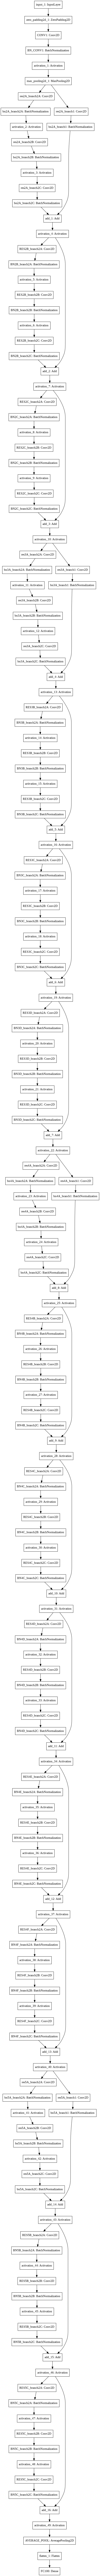

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

## Load Data

In [0]:
from keras.datasets import cifar100
(X_Org, Y_Org), (X_TestO, Y_TestO) = cifar100.load_data() 

169009152/169001437 [==============================] - 6s 0us/step


In [0]:
X_Org[0].shape

(32, 32, 3)

In [0]:
X_train = X_Org/255.
X_test = X_TestO/255.
Y_train = OneHotEncoding(Y_Org, 100).T
Y_test = OneHotEncoding(Y_TestO, 100).T
print (f"Training examples = {str(X_train.shape[0])}, Testing Example = {str(X_test.shape[0])}")
print (f"Shape: X_Train = {str(X_train.shape)}, Y_Train = {str(Y_train.shape)}), X_Test = {str(X_test.shape)}, Y_Test = {str(Y_test.shape)}")

Training examples = 50000, Testing Example = 10000
Shape: X_Train = (50000, 32, 32, 3), Y_Train = (50000, 100)), X_Test = (10000, 32, 32, 3), Y_Test = (10000, 100)


## Running the Model

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'top_k_categorical_accuracy'])
model.fit(X_train, Y_train, epochs = 10, batch_size = 32)

Epoch 1/10
50000/50000 [==============================] - 143s 3ms/step - loss: 1.4664 - acc: 0.5875 - top_k_categorical_accuracy: 0.8687
Epoch 2/10
50000/50000 [==============================] - 132s 3ms/step - loss: 1.2503 - acc: 0.6394 - top_k_categorical_accuracy: 0.9034
Epoch 3/10
50000/50000 [==============================] - 128s 3ms/step - loss: 1.1230 - acc: 0.6748 - top_k_categorical_accuracy: 0.9218
Epoch 4/10
50000/50000 [==============================] - 133s 3ms/step - loss: 0.8749 - acc: 0.7419 - top_k_categorical_accuracy: 0.9516
Epoch 5/10
50000/50000 [==============================] - 132s 3ms/step - loss: 0.7265 - acc: 0.7839 - top_k_categorical_accuracy: 0.9664
Epoch 6/10
50000/50000 [==============================] - 131s 3ms/step - loss: 0.5124 - acc: 0.8478 - top_k_categorical_accuracy: 0.9840
Epoch 7/10
50000/50000 [==============================] - 129s 3ms/step - loss: 0.4194 - acc: 0.8738 - top_k_categorical_accuracy: 0.9892
Epoch 8/10
50000/50000 [==========

In [0]:
def calculateFlop(model):
    runMeta = tf.RunMetadata()
    option = tf.profiler.ProfileOptionBuilder.float_operation()
    flops = tf.profiler.profile(graph=K.get_session().graph, run_meta=runMeta, cmd='op', options=option)
    return flops.total_float_ops


In [0]:
Predict = model.evaluate(X_test, Y_test)
print (f"Loss =  {str(Predict[0])}, Test Accuracy = {str(Predict[1])}")

10000/10000 [==============================] - 4s 430us/step
Loss =  3.7732714126586915, Test Accuracy = 0.3565


In [0]:
print ("Top 1 Error = " + str((1-Predict[1])*100)+ "%")
print ("Top 5 Error = " + str((1-Predict[2])*100)+ "%")

Top 1 Error = 64.35%
Top 5 Error = 36.870000000000005%


In [0]:
print(f"No of Total parameters = {model.count_params()}")
print(f"No of Flops is = {calculateFlop(model)}")

No of Total parameters = 23792612
No of Flops is = 759745152


In [0]:
from google.colab import drive
drive.mount('/content/drive')
model.save('/content/drive/My Drive/AdvancedDeepLearning/Resnet50_With_SE_Cifar100_Colab.h5')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
